In [2]:
import tarfile
import os

tar_file_path = "/content/HlyijOkS9mjEPwVBTuLl0yK9iGWGfboQQT8HBftvKCio5zfDZoKe296aiNRXX4OXXX1fTWoMaAIzOiW3iUOQZ3IjugRDwlogSRADTK8sHRClmJ16mNIMa3RLBdB3.tar"

# Create a directory to extract the contents into
extracted_dir = "BDD10K"
os.makedirs(extracted_dir, exist_ok=True)

# Open and extract the tar file
with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall(path=extracted_dir)

print(f"Tar file extracted to: {extracted_dir}")

Tar file extracted to: BDD10K


In [ ]:
import os
import cv2
import random
from glob import glob
from tqdm import tqdm
from shutil import copyfile

input_dir = "/content/BDD10K/train/img"
output_dir = "/content/roadrep_lora/data/processed"
os.makedirs(output_dir, exist_ok=True)

def downsample_images(input_dir, output_dir, size=(224, 224), max_images=30000):
    image_paths = glob(os.path.join(input_dir, "*.jpg"))
    random.shuffle(image_paths)
    selected = image_paths[:max_images]

    for path in tqdm(selected, desc="Downsampling images"):
        img = cv2.imread(path)
        img = cv2.resize(img, size)
        out_path = os.path.join(output_dir, os.path.basename(path))
        cv2.imwrite(out_path, img)

downsample_images(input_dir, output_dir)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 72.6 MB/s eta 0:00:00


Downsampling images: 100%|██████████| 679/679 [00:03<00:00, 214.06it/s]


### Image Captioning using BLIP

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch
import json

device = "cuda" if torch.cuda.is_available() else "cpu"
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

def generate_caption(image_path):
    raw_image = Image.open(image_path).convert('RGB')
    inputs = processor(raw_image, return_tensors="pt").to(device)
    out = model.generate(**inputs)
    return processor.decode(out[0], skip_special_tokens=True)

image_dir = output_dir
caption_output_path = "/content/roadrep_lora/data/captions/blip_captions.json"
captions = {}

image_paths = glob(os.path.join(image_dir, "*.jpg"))[:5000]  # Test on first 5k

for img_path in tqdm(image_paths, desc="Generating captions"):
    try:
        caption = generate_caption(img_path)
        captions[os.path.basename(img_path)] = caption
    except:
        continue

os.makedirs(os.path.dirname(caption_output_path), exist_ok=True)

with open(caption_output_path, "w") as f:
    json.dump(captions, f, indent=2)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.1 MB/s eta 0:00:00


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]


Generating captions: 100%|██████████| 679/679 [02:44<00:00,  4.13it/s]


### STEP 3: LoRA Fine-Tuning Setup

In [ ]:
from transformers import CLIPProcessor, CLIPModel
from peft import get_peft_model, LoraConfig, TaskType

# Load model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Apply LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.FEATURE_EXTRACTION
)

clip_lora = get_peft_model(clip_model, lora_config)
clip_lora.print_trainable_parameters()

# Optional: Save model for checkpointing
clip_lora.save_pretrained("/content/roadrep_lora/checkpoints/lora_clip_init")


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

trainable params: 491,520 || all params: 151,768,833 || trainable%: 0.3239


In [6]:
!pip install -q pytorch-lightning transformers peft datasets timm wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 31.9 MB/s eta 0:00:00


In [11]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset
from transformers import CLIPProcessor
import pytorch_lightning as pl


class RoadRepDataset(Dataset):
    def __init__(self, image_dir, caption_json, processor, max_samples=None):
        self.image_dir = image_dir
        self.processor = processor

        with open(caption_json, "r") as f:
            self.data = json.load(f)

        if max_samples:
            self.data = dict(list(self.data.items())[:max_samples])

        self.items = list(self.data.items())

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_name, caption = self.items[idx]
        image_path = os.path.join(self.image_dir, img_name)
        image = Image.open(image_path).convert("RGB")
        return image, caption


In [12]:
from transformers import CLIPModel

class RoadRepLightningModule(pl.LightningModule):
    def __init__(self, dataset, processor, lr=1e-4):
        super().__init__()
        self.save_hyperparameters(ignore=['dataset', 'processor'])

        self.processor = processor
        self.dataset = dataset

        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

        # Unfreeze all parameters
        for param in self.model.parameters():
            param.requires_grad = True

        # LoRA config (only for text encoder)
        lora_config = LoraConfig(
            r=8,
            lora_alpha=32,
            target_modules=["q_proj", "v_proj"],
            lora_dropout=0.1,
            bias="none",
            task_type=TaskType.FEATURE_EXTRACTION
        )

        # Apply LoRA only to the text encoder
        from peft import get_peft_model, prepare_model_for_kbit_training
        from peft.utils.other import transpose
        from peft.tuners.lora import LoraLayer

        # Apply LoRA to only the attention blocks manually
        for name, module in self.model.text_model.named_modules():
            if "self_attn" in name:
                for sub_name, sub_module in module.named_modules():
                    if isinstance(sub_module, torch.nn.Linear):
                        # wrap q_proj / v_proj manually
                        if "q_proj" in sub_name or "v_proj" in sub_name:
                            # you can print(name, sub_name) to debug this manually
                            pass  # Here, manually replace with a LoRA-wrapped version if needed


    def training_step(self, batch, batch_idx):
        outputs = self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            pixel_values=batch["pixel_values"],
            return_loss=True
        )
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.hparams.lr)

    def train_dataloader(self):
        return DataLoader(
            self.dataset,
            batch_size=64,
            shuffle=True,
            num_workers=2,
            collate_fn=self.collate_fn
        )

    def collate_fn(self, batch):
        images, texts = zip(*batch)
        inputs = self.processor(
            text=list(texts),
            images=list(images),
            return_tensors="pt",
            padding=True,
            truncation=True
        )
        return {
            "input_ids": inputs["input_ids"],
            "attention_mask": inputs["attention_mask"],
            "pixel_values": inputs["pixel_values"]
        }

In [13]:
import wandb
wandb.finish()  # resets any previous session

# Then re-create the logger cleanly
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(project="roadrep-lora")

In [23]:
from transformers import CLIPProcessor
from pytorch_lightning.loggers import WandbLogger
import wandb
from torch.utils.data import DataLoader

# Reset W&B
wandb.finish()
wandb.login()
wandb_logger = WandbLogger(project="roadrep-lora")

# Load data
image_dir = "/content/roadrep_lora/data/processed"
caption_json = "/content/roadrep_lora/data/captions/blip_captions.json"

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
dataset = RoadRepDataset(image_dir, caption_json, processor, max_samples=5000)

# Model
model = RoadRepLightningModule(dataset=dataset, processor=processor)

# Trainer
from pytorch_lightning import Trainer
trainer = Trainer(
    max_epochs=50,
    accelerator="auto",
    precision="16-mixed",
    logger=wandb_logger,
    callbacks=[
        pl.callbacks.ModelCheckpoint(dirpath="./checkpoints", save_top_k=1, monitor="train_loss")
    ]
)

trainer.fit(model)


epoch,▁█
train_loss,█▁
trainer/global_step,▁█
epoch,9
train_loss,4.15826
trainer/global_step,99


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params | Mode
-------------------------------------------
0 | model | CLIPModel | 151 M  | eval
-------------------------------------------
151 M     Trainable params
0         Non-trainable params
151 M     Total params
605.109   Total estimated model params size (MB)
0         Modules in train mode
306       Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [24]:
model.model.save_pretrained("roadrep_clip_finetuned")
processor.save_pretrained("roadrep_clip_finetuned")

[]

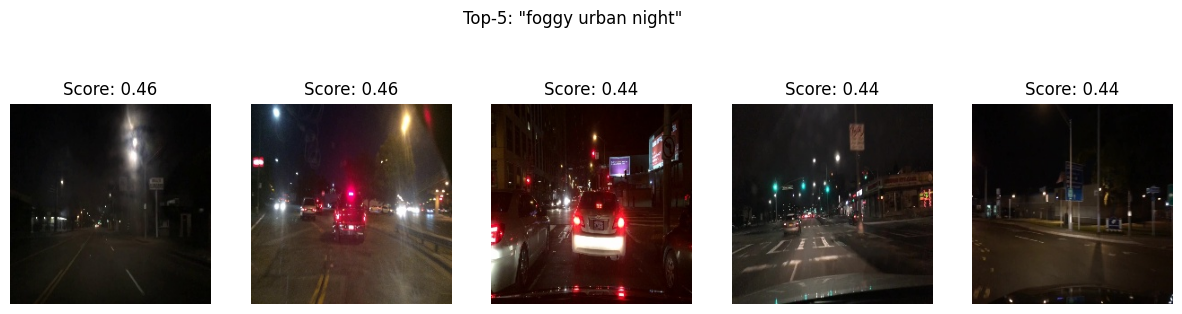

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from PIL import Image
import os

# Load model & processor
model = CLIPModel.from_pretrained("roadrep_clip_finetuned").to(device)
processor = CLIPProcessor.from_pretrained("roadrep_clip_finetuned")
model.eval()

# Embed the text query
query = "foggy urban night"
with torch.no_grad():
    text_inputs = processor(text=[query], return_tensors="pt", padding=True).to(device)
    text_embed = model.get_text_features(**text_inputs)
    text_embed /= text_embed.norm(dim=-1, keepdim=True)

# Encode all images
image_folder = "/content/roadrep_lora/data/processed"
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)]

image_embeds = []
raw_images = []

for path in image_paths:
    image = Image.open(path).convert("RGB")
    raw_images.append(image)
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        img_feat = model.get_image_features(**inputs)
        img_feat /= img_feat.norm(dim=-1, keepdim=True)
        image_embeds.append(img_feat)

image_embeds = torch.cat(image_embeds)
sims = torch.matmul(text_embed, image_embeds.T).squeeze(0)  # (num_images,)
topk = torch.topk(sims, k=5)

# Plot top 5 results
plt.figure(figsize=(15, 4))
for i, idx in enumerate(topk.indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(raw_images[idx])
    plt.title(f"Score: {sims[idx]:.2f}")
    plt.axis("off")
plt.suptitle(f'Top-5: "{query}"')
plt.show()


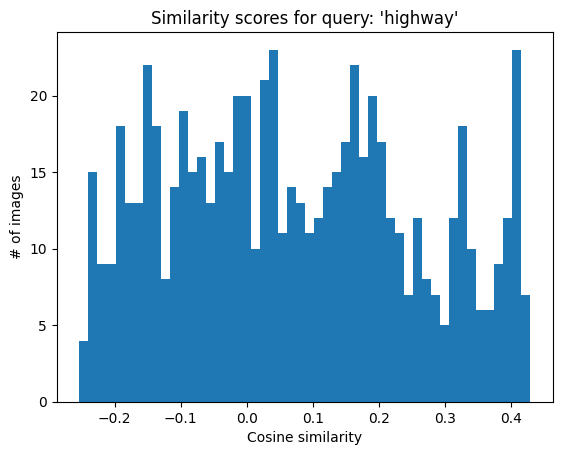

In [26]:
import matplotlib.pyplot as plt

plt.hist(sims.cpu().numpy(), bins=50)
plt.title(f"Similarity scores for query: '{query}'")
plt.xlabel("Cosine similarity")
plt.ylabel("# of images")
plt.show()

### Eval

In [29]:
import wandb
import numpy as np

wandb.init(project="roadrep-lora", name="retrieval-eval")

def evaluate_query(query, model, processor, image_paths):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()

    # Text embedding
    text_inputs = processor(text=[query], return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_embed = model.get_text_features(**text_inputs)
        text_embed /= text_embed.norm(dim=-1, keepdim=True)

    image_embeds = []
    for path in image_paths:
        image = Image.open(path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            img_feat = model.get_image_features(**inputs)
            img_feat /= img_feat.norm(dim=-1, keepdim=True)
            image_embeds.append(img_feat)

    image_embeds = torch.cat(image_embeds)
    sims = torch.matmul(text_embed, image_embeds.T).squeeze(0)  # (num_images,)

    # W&B log
    wandb.log({
        f"{query}_mean_similarity": sims.mean().item(),
        f"{query}_max_similarity": sims.max().item(),
        f"{query}_min_similarity": sims.min().item(),
        f"{query}_std_similarity": sims.std().item()
    })

    return sims

epoch,▁▂▂▃▄▅▅▆▇▇█
train_loss,██▇▇▇▆▅▄▄▃▁
trainer/global_step,▁▂▂▃▄▅▅▆▇▇█
epoch,49
train_loss,1.35734
trainer/global_step,549


### Exporting model to ONNX

In [35]:
import torch
from transformers import CLIPModel

class CLIPONNXWrapper(torch.nn.Module):
    def __init__(self, model: CLIPModel):
        super().__init__()
        self.model = model

    def forward(self, input_ids, attention_mask, pixel_values):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            return_loss=False
        )
        return outputs.logits_per_image, outputs.logits_per_text


In [36]:
model = CLIPModel.from_pretrained("roadrep_clip_finetuned")
model.eval()

wrapper = CLIPONNXWrapper(model).eval()

# Dummy inputs
dummy_image = torch.randn(1, 3, 224, 224)
dummy_input_ids = torch.ones(1, 16, dtype=torch.long)
dummy_attention = torch.ones(1, 16, dtype=torch.long)

# Export
torch.onnx.export(
    wrapper,
    (dummy_input_ids, dummy_attention, dummy_image),
    "roadrep_clip.onnx",
    input_names=["input_ids", "attention_mask", "pixel_values"],
    output_names=["logits_per_image", "logits_per_text"],
    opset_version=16,  # <-- use 14 or higher (16 recommended)
    do_constant_folding=True,
    dynamic_axes={
        "input_ids": {1: "sequence"},
        "attention_mask": {1: "sequence"},
        "pixel_values": {0: "batch", 2: "height", 3: "width"}
    }
)


In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType

quantize_dynamic(
    model_input="roadrep_clip.onnx",
    model_output="roadrep_clip_int8.onnx",
    weight_type=QuantType.QInt8
)


In [39]:
import onnxruntime
import numpy as np
import time

session = onnxruntime.InferenceSession("roadrep_clip.onnx")

# Create dummy input
input_ids = np.ones((1, 16), dtype=np.int64)
attention_mask = np.ones((1, 16), dtype=np.int64)
pixel_values = np.random.rand(1, 3, 224, 224).astype(np.float32)

inputs = {
    "input_ids": input_ids,
    "attention_mask": attention_mask,
    "pixel_values": pixel_values
}

# Benchmark
# Same inputs
start = time.time()
for _ in range(100):
    outputs = session.run(None, inputs)
end = time.time()

fps = 100 / (end - start)
print(f"FP32 Inference throughput: {fps:.2f} FPS")

FP32 Inference throughput: 5.99 FPS
